# Animals classification

In deze notebook wordt er geprobeerd om verschillende images van dieren te voorspellen. De dieren komen vanuit de cifar-10 dataset. Dit wordt gedaan met behulp van CNN.

note: de images zijn gedownload. Er wordt verwacht dat je een directory hebt aangemaakt met deze images in verschillende folders.

### Importeer libraries

In [24]:
import os
import time

import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Maak de features en labels aan

In [25]:
BASE_PATH = './Animals-10/'

X = [] # features
y = [] # labels

animals = ['butterfly', 'cat', 'dog', 'horse', 'sheep'] # alle dieren in de directory

for subdir, _, files in os.walk(BASE_PATH):
    for file in files:
        filepath = subdir + os.sep + file

        if filepath.endswith(".jpg"): # er zijn jpeg en jpg afbeeldingen. Ik heb alleen de jpgs gepakt
            try:
                img = plt.imread(filepath)

                img = cv.resize(img, dsize=(128, 128)) # elke afbeelding even groot maken (100*100)
                #gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # haal rgb weg
                # normaliseer
                img = img.astype(np.float32)
                img /= 255.0
                
                X.append(img)
                y.append(animals.index(file.split()[0]))
            except:
                pass

one-hot-encoding

In [26]:
y = to_categorical(y)

voorbeeld van de encoding

[0. 1. 0. 0. 0.]


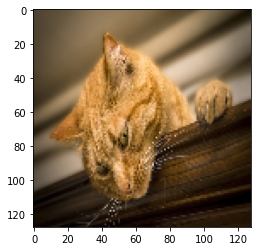

In [27]:
print(y[0])
plt.imshow(X[1])

verander de X en y naar numpy arrays

In [28]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((1238, 128, 128, 3), (1238, 5))

split data in train en test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
X_train.shape, X_test.shape

((990, 128, 128, 3), (248, 128, 128, 3))

[array([0., 0., 0., 0., 1.], dtype=float32)]


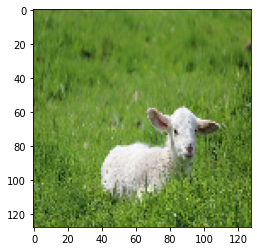

In [70]:
print([y_train[12]])
plt.imshow(X_train[12])

### Model

In [55]:
model = Sequential()

model.add(Conv2D(filters=64,kernel_size=(3, 3),activation='relu', input_shape=(128,128, 3)))
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation = 'softmax'))


In [56]:
model.compile(optimizer='adam',
            metrics = ['accuracy'],
            loss = 'categorical_crossentropy')

In [57]:
start = time.time()
history = model.fit(X_train,y_train,epochs=10,batch_size = 32, validation_split=0.1)

end = time.time()
train_time = end - start
print('train time: ', train_time)

Epoch 1/10


2022-04-28 20:03:30.409574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 3s 88ms/step - loss: 1.2748 - accuracy: 0.4725 - val_loss: 0.9464 - val_accuracy: 0.6768
Epoch 2/10


2022-04-28 20:03:33.121913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 2s 77ms/step - loss: 0.7722 - accuracy: 0.6712 - val_loss: 0.8715 - val_accuracy: 0.6970
Epoch 3/10
28/28 [==============================] - 2s 78ms/step - loss: 0.6842 - accuracy: 0.7160 - val_loss: 0.8768 - val_accuracy: 0.6667
Epoch 4/10
28/28 [==============================] - 2s 77ms/step - loss: 0.5497 - accuracy: 0.7868 - val_loss: 0.8345 - val_accuracy: 0.7172
Epoch 5/10
28/28 [==============================] - 2s 78ms/step - loss: 0.4895 - accuracy: 0.8159 - val_loss: 0.6935 - val_accuracy: 0.7576
Epoch 6/10
28/28 [==============================] - 2s 77ms/step - loss: 0.3851 - accuracy: 0.8563 - val_loss: 0.7363 - val_accuracy: 0.7576
Epoch 7/10
28/28 [==============================] - 2s 77ms/step - loss: 0.3514 - accuracy: 0.8642 - val_loss: 0.6684 - val_accuracy: 0.7778
Epoch 8/10
28/28 [==============================] - 2s 78ms/step - loss: 0.2714 - accuracy: 0.9113 - val_loss: 0.7024 - val_accuracy: 0.7677
Epoch 9/10
28/28 [======

In [60]:
loss, acc = model.evaluate(X_test,
                         y_test)

8/8 [==============================] - 0s 45ms/step - loss: 0.7431 - accuracy: 0.7742


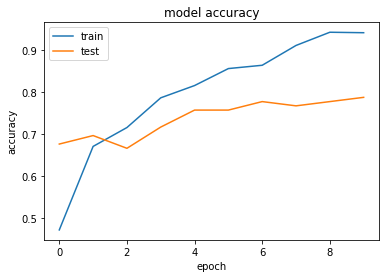

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

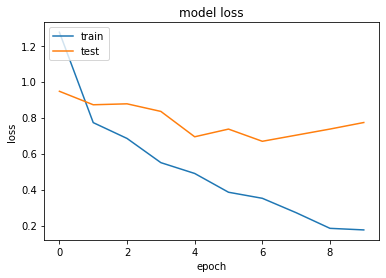

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
X_train.shape

(990, 128, 128, 3)

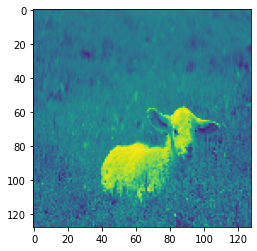

In [71]:
tet = cv.cvtColor(X_train[12], cv.COLOR_BGR2GRAY)

plt.imshow(tet)

In [86]:
X_train_grayscaled = []
X_test_grayscaled = []

for img in X_train:
    gray_scaled_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    X_train_grayscaled.append(gray_scaled_img)

for img in X_test:
    gray_scaled_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    X_test_grayscaled.append(gray_scaled_img)

X_train_grayscaled = np.array(X_train_grayscaled)
X_test_grayscaled = np.array(X_test_grayscaled)

In [89]:
X_train_grayscaled.shape, X_test_grayscaled.shape

((990, 128, 128), (248, 128, 128))

In [90]:
X_train_reshaped = X_train_grayscaled.reshape(990, 128*128)
X_test_reshaped = X_test_grayscaled.reshape(248, 128*128)

In [92]:
X_train_reshaped.shape, X_test_reshaped.shape

((990, 16384), (248, 16384))

In [108]:
model = Sequential()

model.add(Dense(128,activation = 'relu',input_shape=(128*128,)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(5,activation = 'softmax'))

model.compile(optimizer='adam',
            metrics = ['accuracy'],
            loss = 'categorical_crossentropy')

In [109]:
start = time.time()
history = model.fit(X_train_reshaped,y_train,epochs=10,batch_size = 32, validation_split=0.1)

end = time.time()
train_time = end - start
print('train time: ', train_time)

Epoch 1/10
 1/28 [>.............................] - ETA: 8s - loss: 1.6340 - accuracy: 0.2500

2022-04-28 20:27:54.983568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 1s 20ms/step - loss: 1.8230 - accuracy: 0.3625 - val_loss: 1.2137 - val_accuracy: 0.3636
Epoch 2/10
 6/28 [=====>........................] - ETA: 0s - loss: 1.2577 - accuracy: 0.3802

2022-04-28 20:27:55.570555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 14ms/step - loss: 1.2599 - accuracy: 0.3951 - val_loss: 1.0656 - val_accuracy: 0.4242
Epoch 3/10
28/28 [==============================] - 0s 14ms/step - loss: 1.1620 - accuracy: 0.4501 - val_loss: 1.3626 - val_accuracy: 0.4040
Epoch 4/10
28/28 [==============================] - 0s 16ms/step - loss: 1.0659 - accuracy: 0.4691 - val_loss: 1.7683 - val_accuracy: 0.3636
Epoch 5/10
28/28 [==============================] - 0s 15ms/step - loss: 0.9970 - accuracy: 0.5129 - val_loss: 1.1601 - val_accuracy: 0.3838
Epoch 6/10
28/28 [==============================] - 0s 14ms/step - loss: 1.0390 - accuracy: 0.5084 - val_loss: 1.1594 - val_accuracy: 0.4444
Epoch 7/10
28/28 [==============================] - 0s 14ms/step - loss: 0.9443 - accuracy: 0.5657 - val_loss: 1.1075 - val_accuracy: 0.4747
Epoch 8/10
28/28 [==============================] - 0s 14ms/step - loss: 0.9208 - accuracy: 0.5589 - val_loss: 1.0578 - val_accuracy: 0.4444
Epoch 9/10
28/28 [======

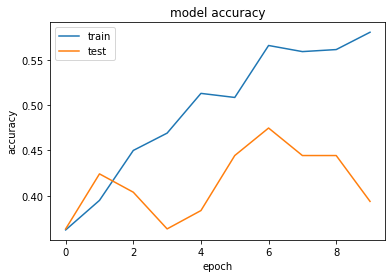

In [110]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

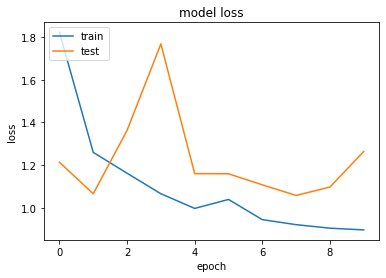

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Conclusie

DE CNN model doet het veel beter dan een normale Dense neurale netwerk. Dit was ook wel te verwachten. De Dense netwerk is wel heel wat sneller qua trainen.

Bij beide modellen is er sprake van overfitting. Misschien kan het handig zijn om nog even te spelen met het aantal neuronen en aantal Conv2D layers. Een percentage is 78 accuracy is niet verkeerd. Toch denk ik dat het beter kan als we de model optimaliseren.